In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
df = sns.load_dataset('titanic')
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [3]:
df.isnull().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

Removing columns that are repeated and have very high null values


In [4]:
df = df.drop(['alive','class','sex','embark_town','deck','age'], axis=1)

In [5]:
df = df.dropna()

In [6]:
X = df.drop(['survived'], axis=1)
y = df['survived']

In [7]:
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['bool', 'category', 'object']).columns

In [8]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
encoder = OrdinalEncoder()
X[cat_cols] = encoder.fit_transform(X[cat_cols])

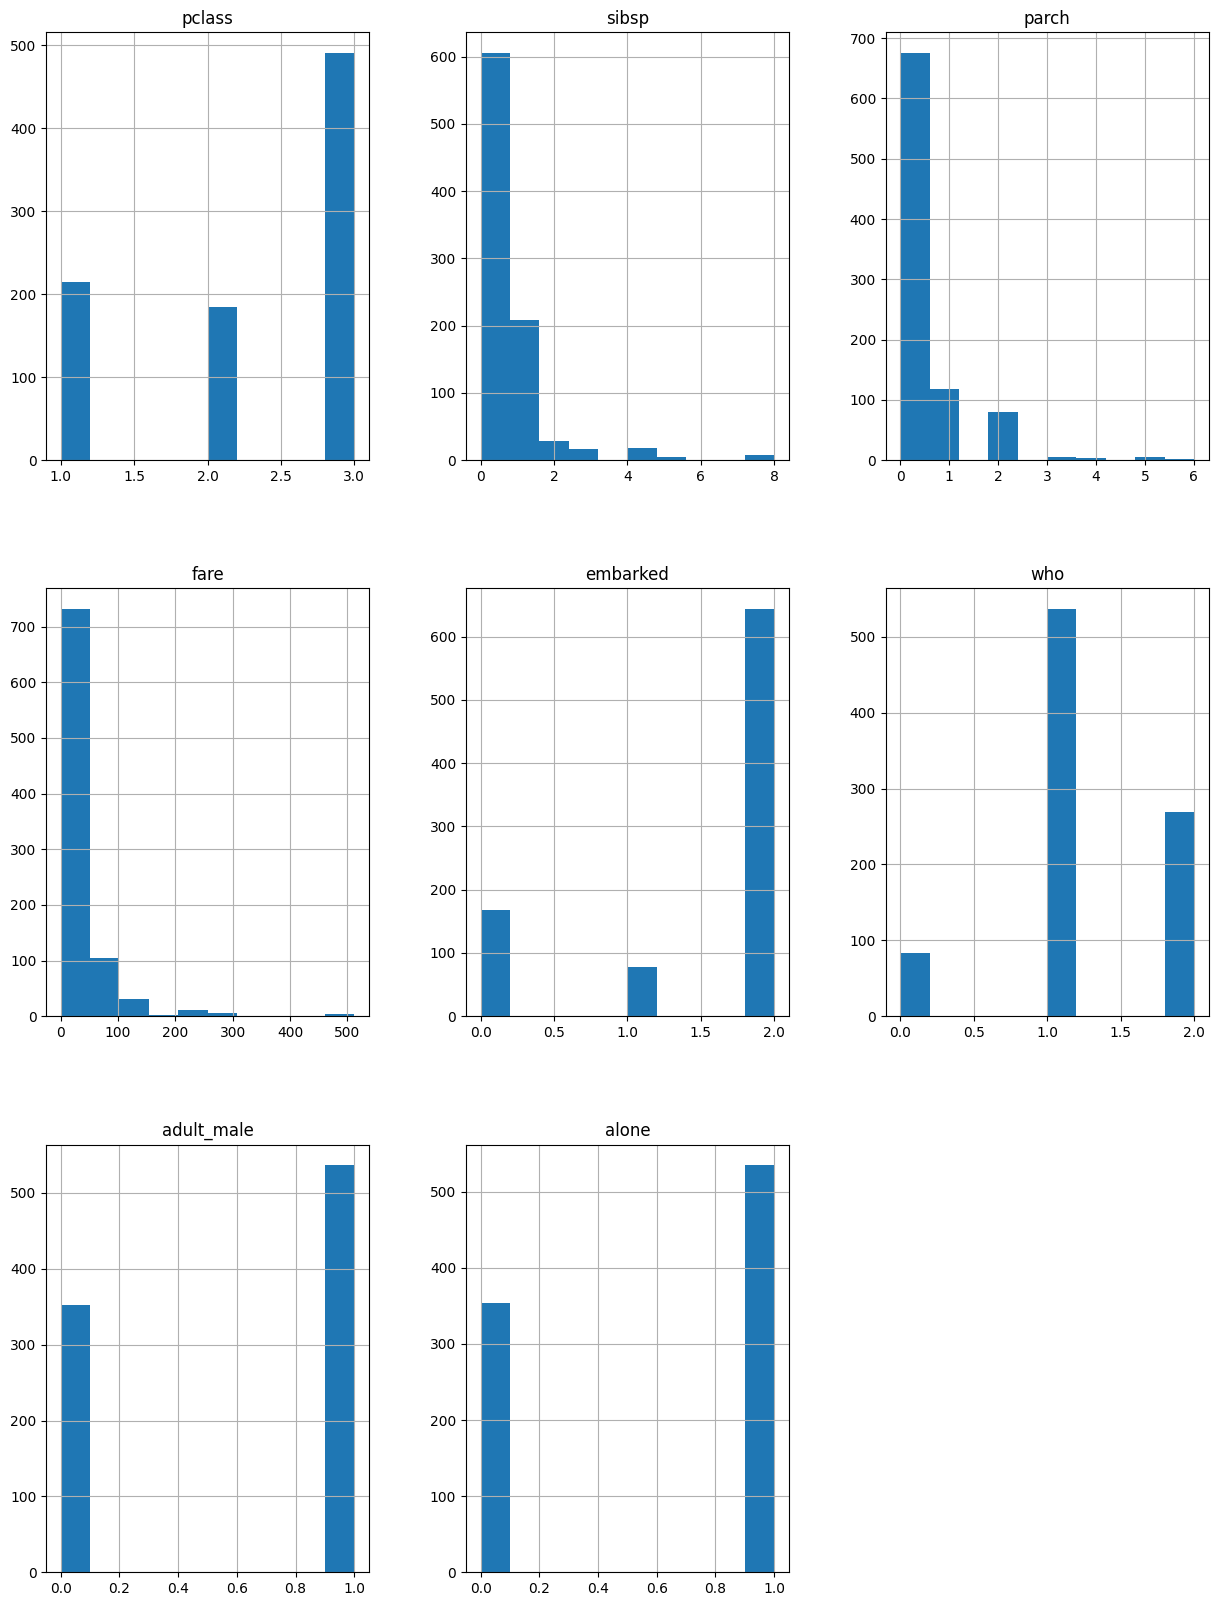

In [9]:
X.hist(figsize=(15,20))
plt.show()

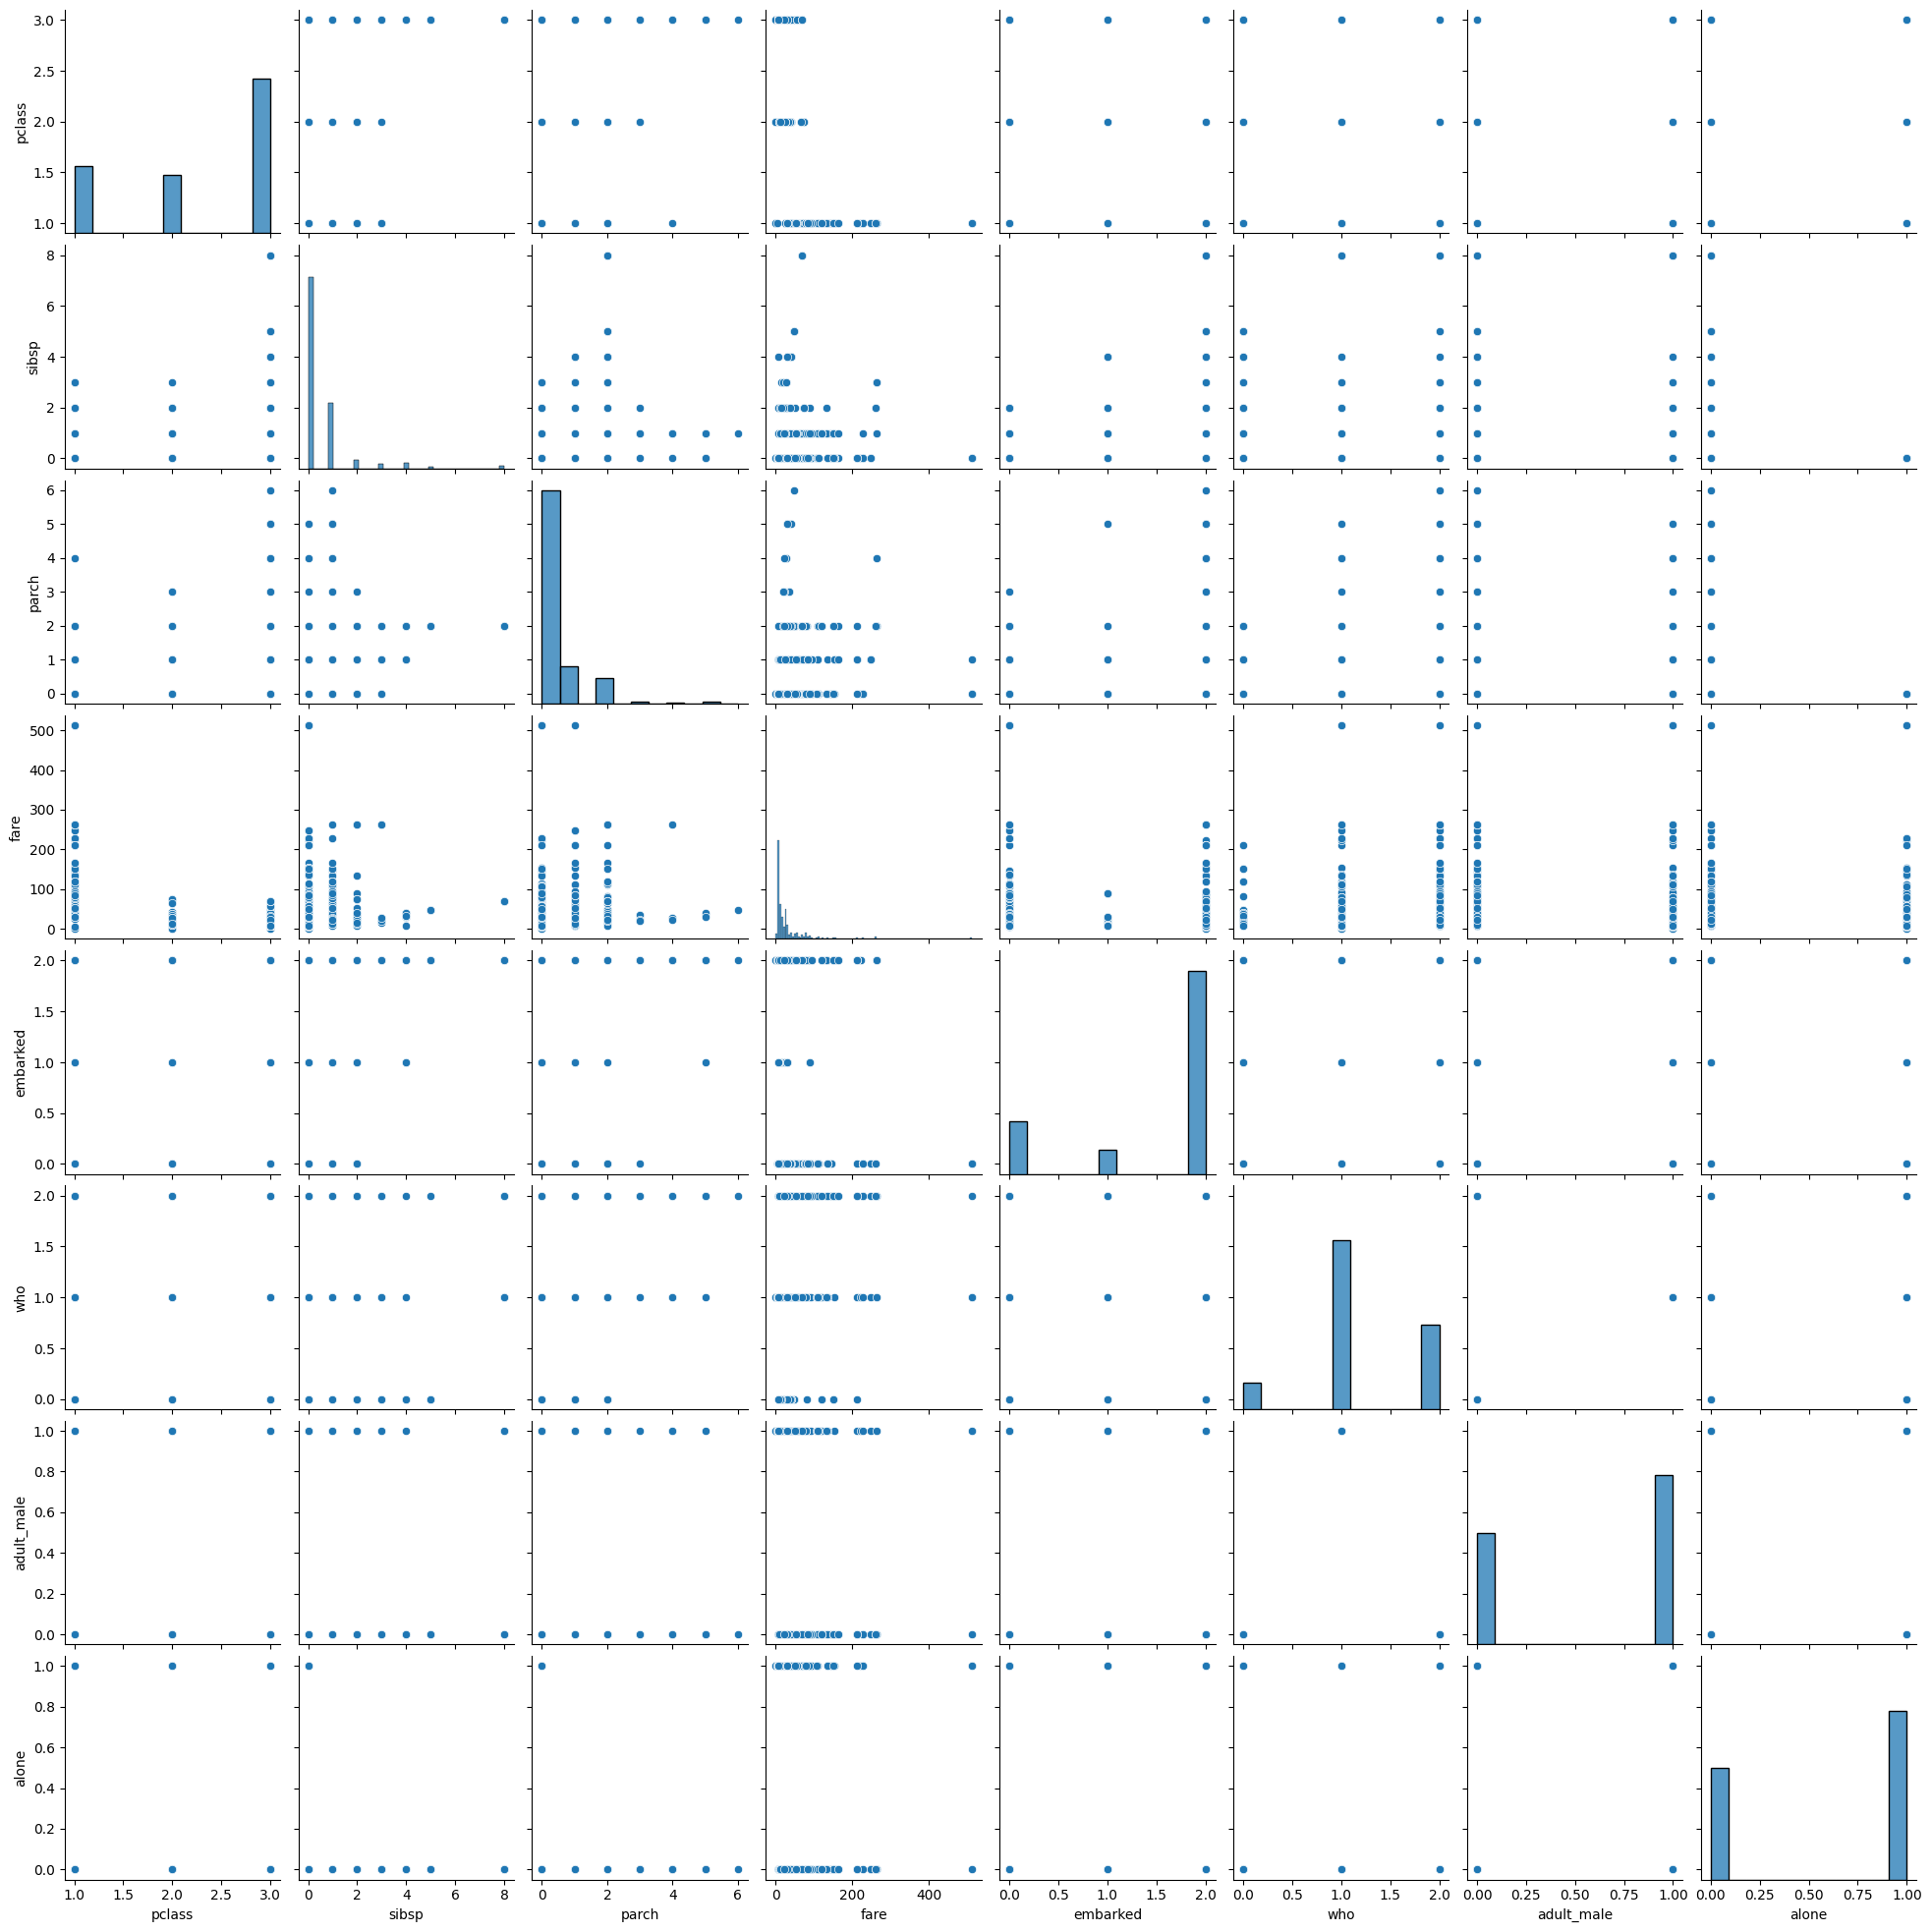

In [10]:
sns.pairplot(X)
plt.show()

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


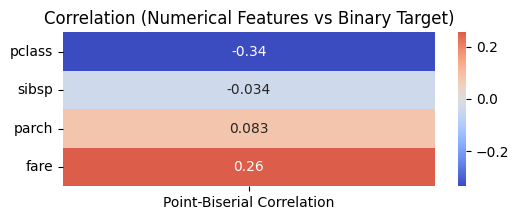

In [11]:
correlations = {}
for col in num_cols:
    corr, _ = pointbiserialr(X[col], y)
    correlations[col] = corr

corr_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Point-Biserial Correlation'])

# Heatmap
plt.figure(figsize=(6, len(corr_df)*0.5))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation (Numerical Features vs Binary Target)')
plt.savefig("Correlation (Numerical Features vs Binary Target).png")
plt.show()


  Feature       VIF
1  pclass  1.506484
2   sibsp  1.244955
3   parch  1.253909
4    fare  1.580229


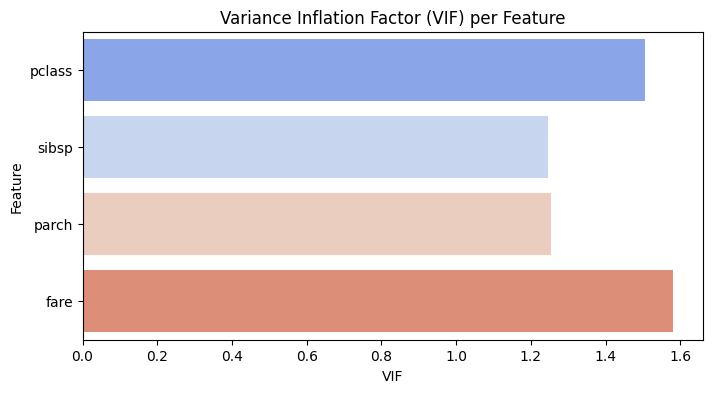

In [12]:
X_num = X[num_cols].dropna()  # Drop NA to avoid VIF errors
X_num = add_constant(X_num)

vif_data = pd.DataFrame()
vif_data['Feature'] = X_num.columns
vif_data['VIF'] = [variance_inflation_factor(X_num.values, i) for i in range(X_num.shape[1])]
vif_data = vif_data[vif_data['Feature'] != 'const']  # Drop constant column from output
print(vif_data)
plt.figure(figsize=(8, 4))
sns.barplot(x='VIF', y='Feature', data=vif_data, palette='coolwarm')
plt.title('Variance Inflation Factor (VIF) per Feature')
plt.show()

In [13]:
X_cat = X[cat_cols].apply(LabelEncoder().fit_transform)
X_cat_scaled = MinMaxScaler().fit_transform(X_cat)

chi2_scores, p_values = chi2(X_cat_scaled, y)

chi2_results = pd.DataFrame({'Feature': cat_cols, 'Chi2 Score': chi2_scores, 'p-value': p_values})
print(chi2_results)


      Feature  Chi2 Score       p-value
0    embarked    5.225800  2.225420e-02
1         who   13.522110  2.357692e-04
2  adult_male  108.628232  1.957663e-25
3       alone   15.052511  1.045610e-04


In [14]:
X_best = X.drop(['embarked', 'sibsp', 'parch'], axis=1)

In [15]:
num_cols = num_cols.difference(['sibsp', 'parch'])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_best, y, test_size=0.2, random_state=42)

In [17]:
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])

In [18]:
pipeline = Pipeline([
    ('logreg', LogisticRegression(max_iter=1000, class_weight='balanced'))
])


param_grid = {
    'logreg__penalty': ['l1', 'l2'],
    'logreg__C': [0.01, 0.1, 1, 10],
    'logreg__solver': ['liblinear', 'saga']
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# GridSearch
grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy')
grid.fit(X_train, y_train)

# Best parameters and score
print(grid.best_params_)
print("Best Accuracy:", grid.best_score_)

{'logreg__C': 0.1, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}
Best Accuracy: 0.7566926031714765


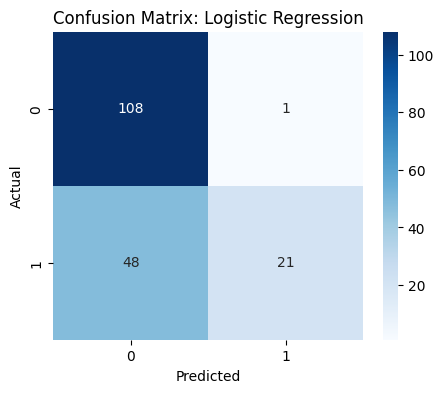

In [19]:
grid.score(X_test, y_test)
cm = confusion_matrix(y_test, grid.predict(X_test))
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Logistic Regression')
plt.savefig("confusion_logistic.png")
plt.show()
          

In [20]:
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [21]:
grid.score(X_test, y_test)

0.7752808988764045

In [22]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    labels=None
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()



Accuracy: 0.7752808988764045

Confusion Matrix:
 [[80 29]
 [11 58]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.73      0.80       109
           1       0.67      0.84      0.74        69

    accuracy                           0.78       178
   macro avg       0.77      0.79      0.77       178
weighted avg       0.80      0.78      0.78       178



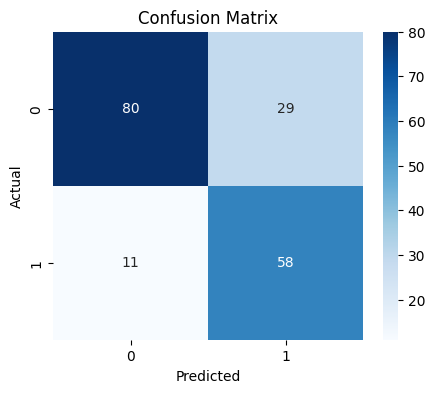

In [23]:
evaluate_model(grid, X_test, y_test)

In [24]:
X_train_t ,X_test_t, y_train_t, y_test_t = train_test_split(df.drop(['survived'], axis=1), df['survived'], test_size=0.2)

In [25]:
num_features = X_train_t.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X_train_t.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()        # categorical column

# Preprocessing
# Create transformers
num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('ordinal', OrdinalEncoder())
])

# Combine with ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

# Final pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier())
])

In [26]:

param_grid = [
    {
        'model': [RandomForestClassifier()],
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 5, 10, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
    
    },
    {
        'model': [DecisionTreeClassifier()],
        'model__max_depth': [None, 5, 10, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        
        
    },
    {
        'model': [GradientBoostingClassifier()],
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__max_depth': [3, 5, 7],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
    
    }
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# GridSearchCV
search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy')
search.fit(X_train_t, y_train_t)

print("Best Parameters:", search.best_params_)
print("Best Score:", search.best_score_)

Best Parameters: {'model': GradientBoostingClassifier(learning_rate=0.05, max_depth=5, min_samples_leaf=2), 'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Best Score: 0.8438885058603368


accuracy score: 0.8370786516853933
              precision    recall  f1-score   support

           0       0.81      0.94      0.87       101
           1       0.90      0.70      0.79        77

    accuracy                           0.84       178
   macro avg       0.85      0.82      0.83       178
weighted avg       0.85      0.84      0.83       178



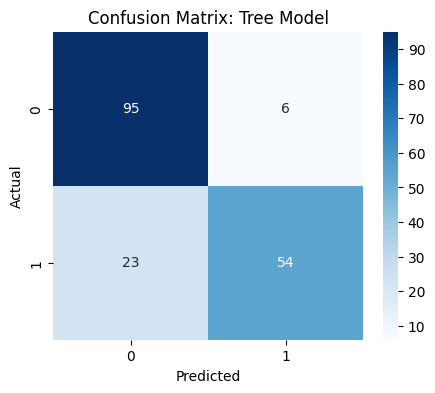

In [27]:
print(f"accuracy score: {accuracy_score(search.predict(X_test_t), y_test_t)}")
print(classification_report(y_test_t, search.predict(X_test_t)))
cm = confusion_matrix(y_test_t, search.predict(X_test_t))
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Tree Model')
plt.savefig("confusion_Tree.png")
plt.show()